In [2]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout,Dense,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Using TensorFlow backend.


In [3]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [4]:
#load the data

training_set = pd.read_csv('fashion-mnist_train.csv')
testing_set = pd.read_csv('fashion-mnist_test.csv')



In [5]:
#Preprocess the data 
# Reshape the given csv into the original images


# Creation of validation dataset to improve model performance evalutation
X = np.array(training_set.iloc[:,1:])
X = X.reshape(X.shape[0],28,28,1).astype('float32')
X = X/255
y = to_categorical(np.array(training_set.iloc[:,0])) 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=seed)

X_test = np.array(testing_set.iloc[:,1:])
X_test = X_test.reshape(X_test.shape[0],28,28,1).astype('float32')
X_test = X_test/255
y_test = to_categorical(np.array(testing_set.iloc[:,0]))


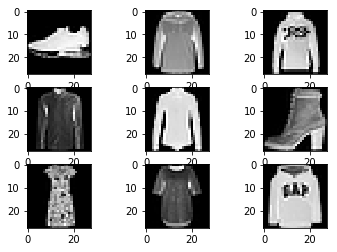

In [7]:
# Check if the reshaping worked by displaying the 9 first images 

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(np.squeeze(X_train[i]), cmap='gray')
plt.show()

In [6]:
# Building a cnn model
shape = (28,28,1)
number_of_classes = y_test.shape[1]
def create_model():
    model = Sequential()
    model.add(Conv2D(32,(5,5),activation ='relu',input_shape = shape ))
    model.add(Conv2D(32,(5,5),activation ='relu',input_shape = shape ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(5,5),activation ='relu' ))
    model.add(Conv2D(64,(5,5),activation ='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model


In [13]:
# Early stopping to save the best model 
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1),ModelCheckpoint('best_cnn.h5', monitor='val_loss', save_best_only=True)]

In [14]:
# Training the model
batch_size = 150
epochs = 20
model = create_model()
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks,
                    verbose=1,
validation_data=(X_val, y_val))

Train on 40200 samples, validate on 19800 samples
Epoch 1/20
40200/40200 [==============================] - 461s 11ms/step - loss: 0.6056 - acc: 0.7804 - val_loss: 1.2449 - val_acc: 0.5323
Epoch 2/20
40200/40200 [==============================] - 433s 11ms/step - loss: 0.3842 - acc: 0.8611 - val_loss: 0.4041 - val_acc: 0.8633
Epoch 3/20
40200/40200 [==============================] - 447s 11ms/step - loss: 0.3286 - acc: 0.8793 - val_loss: 0.3060 - val_acc: 0.8889
Epoch 4/20
40200/40200 [==============================] - 415s 10ms/step - loss: 0.2954 - acc: 0.8922 - val_loss: 0.3173 - val_acc: 0.8892
Epoch 5/20
40200/40200 [==============================] - 392s 10ms/step - loss: 0.2723 - acc: 0.9004 - val_loss: 0.2835 - val_acc: 0.8971
Epoch 6/20
40200/40200 [==============================] - 407s 10ms/step - loss: 0.2503 - acc: 0.9078 - val_loss: 0.2965 - val_acc: 0.8914
Epoch 7/20
40200/40200 [==============================] - 438s 11ms/step - loss: 0.2382 - acc: 0.9134 - val_loss: 0.

In [7]:
# Evaluate the best model

best_model = load_model('best_cnn.h5')
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.223320041239
Test accuracy: 0.9183


In [8]:
# Make predictions about the classes
predictions = best_model.predict_classes(X_test,batch_size=150)  


In [19]:
# Save the classification

filename = 'best_cnn_classification.csv';
PictureID = list(range(1,len(predictions)+1))
submission = pd.DataFrame({'Clothe_category':predictions })
submission.to_csv(filename,header = True, index = False)
print('Saved file: ' + filename)

Saved file: best_cnn_classification.csv


In [20]:
# Data Model visualization
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          102464    
__________

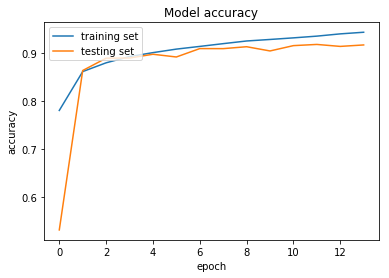

In [21]:
# Accuracy visualization
training_accuracy = history.history['acc']
testing_accuracy = history.history['val_acc']
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.title('Model accuracy')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

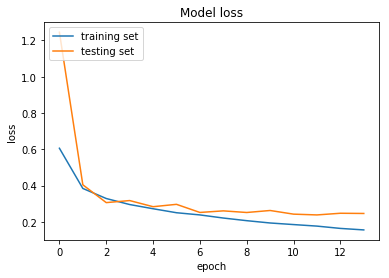

In [22]:
# Loss visualization

training_loss = history.history['loss']
testing_loss = history.history['val_loss']
plt.plot(training_loss)
plt.plot(testing_loss)
plt.title('Model loss')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()


In [10]:
# Studying misclassfications

target_names = ["Class {}".format(i) for i in range(number_of_classes)]
y_true = testing_set.iloc[:,0]

print(classification_report(y_true, predictions, target_names=target_names))



             precision    recall  f1-score   support

    Class 0       0.88      0.85      0.87      1000
    Class 1       1.00      0.97      0.99      1000
    Class 2       0.90      0.86      0.88      1000
    Class 3       0.90      0.93      0.92      1000
    Class 4       0.85      0.89      0.87      1000
    Class 5       0.98      0.98      0.98      1000
    Class 6       0.77      0.78      0.78      1000
    Class 7       0.95      0.97      0.96      1000
    Class 8       0.98      0.99      0.98      1000
    Class 9       0.97      0.96      0.97      1000

avg / total       0.92      0.92      0.92     10000



In [12]:
print(confusion_matrix(y_true, predictions))

[[848   0  12  34   1   0 101   0   4   0]
 [  1 975   1  16   2   1   4   0   0   0]
 [ 19   0 858  11  55   1  52   0   4   0]
 [ 10   1   2 934  37   0  13   0   3   0]
 [  0   0  37  18 890   1  53   0   1   0]
 [  0   0   0   0   0 980   0  16   1   3]
 [ 82   0  45  27  55   2 782   0   7   0]
 [  0   0   0   0   0   7   0 969   0  24]
 [  0   0   3   1   3   2   5   0 986   0]
 [  0   0   0   0   0   4   0  34   1 961]]
